In [11]:
%matplotlib inline
from astropy.io import ascii
from astropy.table import Table

import sys
import re
import numpy as np
import pylab
import json
import requests
import matplotlib.pyplot as plt

try: # Python 3.x
    from urllib.parse import quote as urlencode
    from urllib.request import urlretrieve
except ImportError:  # Python 2.x
    from urllib import pathname2url as urlencode
    from urllib import urlretrieve

try: # Python 3.x
    import http.client as httplib 
except ImportError:  # Python 2.x
    import httplib   

In [2]:
def ps1cone(ra,dec,radius,table="mean",release="dr1",format="csv",columns=None,
           baseurl="https://catalogs.mast.stsci.edu/api/v0.1/panstarrs", verbose=False,
           **kw):
    """Do a cone search of the PS1 catalog
    
    Parameters
    ----------
    ra (float): (degrees) J2000 Right Ascension
    dec (float): (degrees) J2000 Declination
    radius (float): (degrees) Search radius (<= 0.5 degrees)
    table (string): mean, stack, or detection
    release (string): dr1 or dr2
    format: csv, votable, json
    columns: list of column names to include (None means use defaults)
    baseurl: base URL for the request
    verbose: print info about request
    **kw: other parameters (e.g., 'nDetections.min':2)
    """
    
    data = kw.copy()
    data['ra'] = ra
    data['dec'] = dec
    data['radius'] = radius
    return ps1search(table=table,release=release,format=format,columns=columns,
                    baseurl=baseurl, verbose=verbose, **data)

def ps1search(table="mean",release="dr1",format="csv",columns=None,
           baseurl="https://catalogs.mast.stsci.edu/api/v0.1/panstarrs", verbose=False,
           **kw):
    """Do a general search of the PS1 catalog (possibly without ra/dec/radius)
    
    Parameters
    ----------
    table (string): mean, stack, or detection
    release (string): dr1 or dr2
    format: csv, votable, json
    columns: list of column names to include (None means use defaults)
    baseurl: base URL for the request
    verbose: print info about request
    **kw: other parameters (e.g., 'nDetections.min':2).  Note this is required!
    """
    
    data = kw.copy()
    if not data:
        raise ValueError("You must specify some parameters for search")
    checklegal(table,release)
    if format not in ("csv","votable","json"):
        raise ValueError("Bad value for format")
    url = "{baseurl}/{release}/{table}.{format}".format(**locals())
    if columns:
        # check that column values are legal
        # create a dictionary to speed this up
        dcols = {}
        for col in ps1metadata(table,release)['name']:
            dcols[col.lower()] = 1
        badcols = []
        for col in columns:
            if col.lower().strip() not in dcols:
                badcols.append(col)
        if badcols:
            raise ValueError('Some columns not found in table: {}'.format(', '.join(badcols)))
        # two different ways to specify a list of column values in the API
        # data['columns'] = columns
        data['columns'] = '[{}]'.format(','.join(columns))

# either get or post works
#    r = requests.post(url, data=data)
    r = requests.get(url, params=data)

    if verbose:
        print(r.url)
    r.raise_for_status()
    if format == "json":
        return r.json()
    else:
        return r.text


def checklegal(table,release):
    """Checks if this combination of table and release is acceptable
    
    Raises a VelueError exception if there is problem
    """
    
    releaselist = ("dr1", "dr2")
    if release not in ("dr1","dr2"):
        raise ValueError("Bad value for release (must be one of {})".format(', '.join(releaselist)))
    if release=="dr1":
        tablelist = ("mean", "stack")
    else:
        tablelist = ("mean", "stack", "detection")
    if table not in tablelist:
        raise ValueError("Bad value for table (for {} must be one of {})".format(release, ", ".join(tablelist)))

  
def ps1metadata(table="mean",release="dr1",
           baseurl="https://catalogs.mast.stsci.edu/api/v0.1/panstarrs"):
    """Return metadata for the specified catalog and table
    
    Parameters
    ----------
    table (string): mean, stack, or detection
    release (string): dr1 or dr2
    baseurl: base URL for the request
    
    Returns an astropy table with columns name, type, description
    """
    
    checklegal(table,release)
    url = "{baseurl}/{release}/{table}/metadata".format(**locals())
    r = requests.get(url)
    r.raise_for_status()
    v = r.json()
    # convert to astropy table
    tab = Table(rows=[(x['name'],x['type'],x['description']) for x in v],
               names=('name','type','description'))
    return tab


def mastQuery(request):
    """Perform a MAST query.

    Parameters
    ----------
    request (dictionary): The MAST request json object

    Returns head,content where head is the response HTTP headers, and content is the returned data
    """
    
    server='mast.stsci.edu'

    # Grab Python Version 
    version = ".".join(map(str, sys.version_info[:3]))

    # Create Http Header Variables
    headers = {"Content-type": "application/x-www-form-urlencoded",
               "Accept": "text/plain",
               "User-agent":"python-requests/"+version}

    # Encoding the request as a json string
    requestString = json.dumps(request)
    requestString = urlencode(requestString)
    
    # opening the https connection
    conn = httplib.HTTPSConnection(server)

    # Making the query
    conn.request("POST", "/api/v0/invoke", "request="+requestString, headers)

    # Getting the response
    resp = conn.getresponse()
    head = resp.getheaders()
    content = resp.read().decode('utf-8')

    # Close the https connection
    conn.close()

    return head,content


def resolve(name):
    """Get the RA and Dec for an object using the MAST name resolver
    
    Parameters
    ----------
    name (str): Name of object

    Returns RA, Dec tuple with position"""

    resolverRequest = {'service':'Mast.Name.Lookup',
                       'params':{'input':name,
                                 'format':'json'
                                },
                      }
    headers,resolvedObjectString = mastQuery(resolverRequest)
    resolvedObject = json.loads(resolvedObjectString)
    # The resolver returns a variety of information about the resolved object, 
    # however for our purposes all we need are the RA and Dec
    try:
        objRa = resolvedObject['resolvedCoordinate'][0]['ra']
        objDec = resolvedObject['resolvedCoordinate'][0]['decl']
    except IndexError as e:
        raise ValueError("Unknown object '{}'".format(name))
    return (objRa, objDec)


In [3]:
def fetch_from_name(name, radius=10.0):
    ra, dec = resolve(name)
    radius = radius / 60.0  # so this is in arcminutes
    print(f"Fetching {name} @ ({ra}, {dec}) with radius {radius}")
    constraints = {'nDetections.gt':5}

    # strip blanks and weed out blank and commented-out values
    columns = """objID,raMean,decMean,nDetections,ng,nr,ni,nz,ny,
        qualityFlag,objInfoFlag,
        gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag,
        gMeanPSFMagErr,rMeanPSFMagErr,iMeanPSFMagErr,zMeanPSFMagErr,yMeanPSFMagErr
        """.split(',')
    columns = [x.strip() for x in columns]
    columns = [x for x in columns if x and not x.startswith('#')]
    results = ps1cone(ra,dec,radius,release='dr2',columns=columns,verbose=True,**constraints)

    # print first few lines
    lines = results.split('\n')
    print(len(lines),"rows in results")    

    # make a table:
    tab = ascii.read(results)
    # improve the format
    for filter in 'grizy':
        col = filter+'MeanPSFMag'
        try:
            tab[col].format = ".4f"
            tab[col][tab[col] == -999.0] = np.nan
        except KeyError:
            print("{} not found".format(col))
    print(len(tab))

    # Do czw filtering:
    # https://outerspace.stsci.edu/display/PANSTARRS/PS1+Object+Flags
    tab2Sel = (tab['qualityFlag'] != 1)
    tab2Sel = np.logical_and(tab2Sel, tab['nDetections'] > 10)
    tab2Sel = np.logical_and(tab2Sel, np.isfinite(tab['gMeanPSFMag']))
    tab2Sel = np.logical_and(tab2Sel, np.isfinite(tab['rMeanPSFMag']))
    #tab2Sel = np.logical_and(tab2Sel, np.isfinite(tab['iMeanPSFMag']))
    #tab2Sel = np.logical_and(tab2Sel, tab['gMeanPSFMagErr'] < 0.1)
    # tab2Sel = np.logical_and(tab2Sel, tab['yMeanPSFMag'] < 18.5)
    tab = tab[tab2Sel]
    print(len(tab))
    return tab

def plot_table(table, blue='g', red='r'):
    gLabel = blue + 'MeanPSFMag'
    rLabel = red  + 'MeanPSFMag'
    plt.scatter(table[gLabel] - table[rLabel], table[rLabel], marker='.', s=0.5)
    plt.xlim(-2, 2)
    plt.gca().invert_yaxis()

In [4]:
T = fetch_from_name("M2", radius=26.0)

Fetching M2 @ (323.36258, -0.82325) with radius 0.43333333333333335
https://catalogs.mast.stsci.edu/api/v0.1/panstarrs/dr2/mean.csv?nDetections.gt=5&ra=323.36258&dec=-0.82325&radius=0.43333333333333335&columns=%5BobjID%2CraMean%2CdecMean%2CnDetections%2Cng%2Cnr%2Cni%2Cnz%2Cny%2CqualityFlag%2CobjInfoFlag%2CgMeanPSFMag%2CrMeanPSFMag%2CiMeanPSFMag%2CzMeanPSFMag%2CyMeanPSFMag%2CgMeanPSFMagErr%2CrMeanPSFMagErr%2CiMeanPSFMagErr%2CzMeanPSFMagErr%2CyMeanPSFMagErr%5D
36153 rows in results
36151
24097


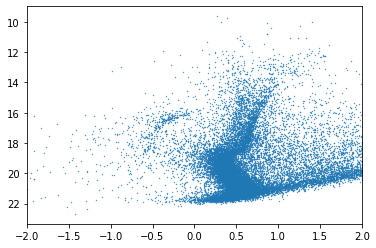

In [12]:
plot_table(T, red='i')

Fetching M5 @ (229.63842, 2.08103) with radius 0.16666666666666666
https://catalogs.mast.stsci.edu/api/v0.1/panstarrs/dr2/mean.csv?nDetections.gt=5&ra=229.63842&dec=2.08103&radius=0.16666666666666666&columns=%5BobjID%2CraMean%2CdecMean%2CnDetections%2Cng%2Cnr%2Cni%2Cnz%2Cny%2CqualityFlag%2CobjInfoFlag%2CgMeanPSFMag%2CrMeanPSFMag%2CiMeanPSFMag%2CzMeanPSFMag%2CyMeanPSFMag%2CgMeanPSFMagErr%2CrMeanPSFMagErr%2CiMeanPSFMagErr%2CzMeanPSFMagErr%2CyMeanPSFMagErr%5D
34682 rows in results
34680
23679


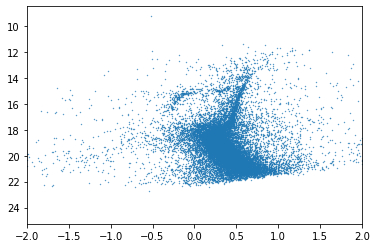

In [13]:
T_M5 = fetch_from_name("M5")
plot_table(T_M5)

Fetching NGC 2682 @ (132.83387, 11.81196) with radius 0.16666666666666666
https://catalogs.mast.stsci.edu/api/v0.1/panstarrs/dr2/mean.csv?nDetections.gt=5&ra=132.83387&dec=11.81196&radius=0.16666666666666666&columns=%5BobjID%2CraMean%2CdecMean%2CnDetections%2Cng%2Cnr%2Cni%2Cnz%2Cny%2CqualityFlag%2CobjInfoFlag%2CgMeanPSFMag%2CrMeanPSFMag%2CiMeanPSFMag%2CzMeanPSFMag%2CyMeanPSFMag%2CgMeanPSFMagErr%2CrMeanPSFMagErr%2CiMeanPSFMagErr%2CzMeanPSFMagErr%2CyMeanPSFMagErr%5D
2069 rows in results
2067
1352


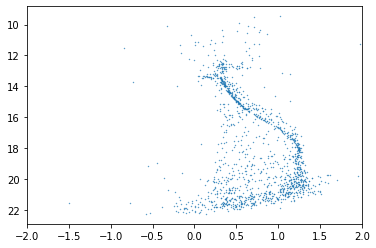

In [14]:
T_2516 = fetch_from_name("NGC 2682")
plot_table(T_2516)

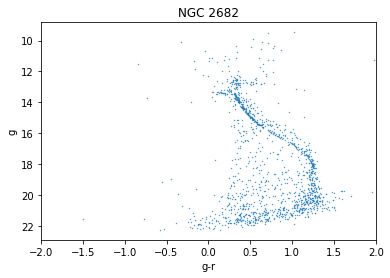

In [15]:
plot_table(T_2516)
plt.xlabel("g-r")
plt.ylabel("g")
plt.title("NGC 2682")
plt.savefig("/tmp/a.png")